In [1]:
import tensorflow as tf

In [2]:
#!pip install tensorflow
#!pip install -q tf-models-official

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.math import confusion_matrix

tf.get_logger().setLevel('ERROR')

/Users/juliennezhao/opt/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [25]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

neg = []
pos = []
neg_label = []
pos_label = []

data = []
label = []

with open("../twitter-datasets/train_neg_full.txt",'r') as file:
    neg = file.read().splitlines()
    neg_label = [0 for i in range(len(neg))]
    file.close()
            
with open("../twitter-datasets/train_pos_full.txt",'r') as file:
    pos = file.read().splitlines()
    pos_label = [1 for i in range(len(pos))]
    file.close()
    
data.append(neg)
data.append(pos)
data = np.ravel(data)
label.append(neg_label)
label.append(pos_label)
label = np.ravel(label)

with open("./vocab_cut.txt",'r') as file:
    cut_vocab = file.read().splitlines()

print("pos: ", np.shape(pos), np.shape(pos_label))
print("neg: ", np.shape(neg), np.shape(neg_label))
print("total: ", np.shape(data), np.shape(label))
print("cut_vocab words: ", np.shape(cut_vocab))

pos:  (1250000,) (1250000,)
neg:  (1250000,) (1250000,)
total:  (2500000,) (2500000,)
cut_vocab words:  (21161,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42, shuffle=True)

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [31]:
print(len(X_train), len(X_test))

2000000 500000


In [32]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [33]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [34]:
VOCAB_SIZE = len(cut_vocab)
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [35]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'user', 'i', 'the', 'to', 'you', 'url', 'a', 'and',
       'my', 'me', 'of', 'is', 'for', 'in', 'it', 'im', 'this', 'on'],
      dtype='<U29')

In [36]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['binary_accuracy'])

In [38]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
15625/15625 [==============================] - 786s 49ms/step - loss: 0.3700 - binary_accuracy: 0.8316 - val_loss: 0.3427 - val_binary_accuracy: 0.8456
Epoch 2/2
15625/15625 [==============================] - 831s 53ms/step - loss: 0.3279 - binary_accuracy: 0.8550 - val_loss: 0.3339 - val_binary_accuracy: 0.8513


In [39]:
model.save_weights('./checkpoints/my_checkpoint3')

In [40]:
model.save('saved_model/my_model3')

In [41]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Mean Squared Error:', test_accuracy)

3907/3907 [==============================] - 44s 11ms/step - loss: 0.3250 - binary_accuracy: 0.8549
Test Loss: 0.3250061869621277
Test Mean Squared Error: 0.8549000024795532


In [42]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0, 0.37209509760141374)

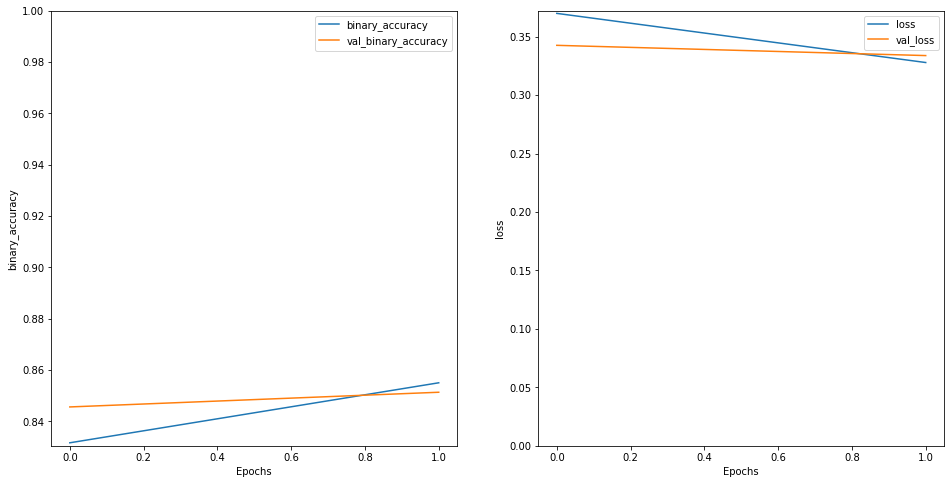

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [44]:
y_pred = model.predict(test_dataset)
y_pred

array([[9.9500167e-01],
       [8.9540064e-01],
       [4.6367779e-07],
       ...,
       [9.5381558e-01],
       [6.3791513e-01],
       [3.5987049e-02]], dtype=float32)

In [47]:
with open("./test_data_cleaned.txt",'r') as file:
    test_data = file.read().splitlines()
    file.close()

In [48]:
len(test_data)

10000

In [49]:
y_final = model.predict(test_data)

In [50]:
y_final[y_final<0.5]=-1
y_final[y_final>=0.5]=1
y_final = np.ravel(y_final.astype('int64'))

In [51]:
y_final[:100]

array([-1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1,
        1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,
       -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1])

In [52]:
np.shape(y_final)

(10000,)

In [53]:
y_solution = zip(range(1, len(y_final)+1), y_final)
sol = pd.DataFrame(y_solution, columns= ['Id', 'Prediction'])
sol.to_csv('submission3.csv', index=False)